구현방법
1. libfm (저자가 만든 package, C++)
2. PytorchFM
3. fastFM
4. xlearn
5. numpy

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy
import math
from tqdm import tqdm
import warnings
import datetime
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/MyDrive/Colab Notebooks/[인턴]2020겨울학기_DSAIL/ml-100k/'

In [30]:
df = pd.read_csv(os.path.join(path,'u.data'), sep='\t', names=['user_id', 'item_id', 'rating', 'time_stamp'])

## Feature Vector 
: user one-hot vector + item one-hot vector + meta info + other feature engineered vectors

### 1. User Feature

In [5]:
user_df = pd.read_csv(os.path.join(path + 'u.user'), sep='|', 
            encoding='utf-8', names = ['user_id','age','gender','occupation','zipcode'])
user_df['user_id'].astype(int)
user_df = user_df.set_index('user_id')
user_df

,age,gender,occupation,zipcode
user_id,,,,
1,24,M,technician,85711
2,53,F,other,94043
3,23,M,writer,32067
4,24,M,technician,43537
5,33,F,other,15213
...,...,...,...,...
939,26,F,student,33319
940,32,M,administrator,02215
941,20,M,student,97229


### Item Feature

In [6]:
item_df = pd.DataFrame(columns=['item_id', 'movie_name', 'release', 'video_release', 'url','unknown', 'Action','Adventure','Animation',
              'Children','Comedy','Crime','Documentary','Drama','Fantasy',
              'Film-Noir','Horror','Musical','Mystery','Romance', 'Sci-Fi',
              'Thriller', 'War','Western'])
r = open(path+'u.item', mode='rt', encoding='latin-1')
for line in r:
  item_df.loc[len(item_df)] = line.replace("\n","").split("|")
r.close()
item_df.drop(266, inplace=True)
item_df['release'] = pd.to_datetime(item_df['release'], format='%d-%b-%Y')
#item_df['item_id'].astype(int)
#item_df = item_df.set_index('item_id')
display(item_df)

,item_id,movie_name,release,video_release,url,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),1995-01-01,,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),1995-01-01,,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),1995-01-01,,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),1995-01-01,,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),1995-01-01,,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),1998-02-06,,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1678,1679,B. Monkey (1998),1998-02-06,,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1679,1680,Sliding Doors (1998),1998-01-01,,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1680,1681,You So Crazy (1994),1994-01-01,,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
dummy_genres_df = pd.concat([item_df[['item_id']], item_df.iloc[:,6:24]], axis=1)
dummy_genres_df[:].astype(int)
dummy_genres_df = dummy_genres_df.apply(pd.to_numeric)
dummy_genres_df

,item_id,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1678,1679,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1679,1680,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1680,1681,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
# genre one-hot vector
dummy_gender = pd.get_dummies(user_df.gender)
# age
age = user_df.age
# occupation
dummy_occupation = pd.get_dummies(user_df.occupation)
user_features = pd.concat([dummy_gender, age, dummy_occupation], axis=1)

In [9]:
start_date = item_df['release'].min()
# time_delta
item_df['month_delta'] = ((item_df['release'] - start_date)/np.timedelta64(1, 'M')).astype(int)
# normalize
time_df = (item_df['month_delta']-item_df['month_delta'].min())/(item_df['month_delta'].max()-item_df['month_delta'].min())
time_df = pd.concat([item_df[['item_id']].astype(int), time_df], axis=1)

In [18]:
df = pd.merge(df, dummy_gender, left_on='user_id', right_on='user_id', how='left')
df = pd.merge(df, dummy_genres_df, left_on='item_id', right_on='item_id', how='left')
#df = pd.merge(df, time_df, left_on='item_id', right_on='item_id', how='left')
df

,user_id,item_id,rating,time_stamp,F,M,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,196,242,3,881250949,0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,186,302,3,891717742,1,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,22,377,1,878887116,0,1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,244,51,2,880606923,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
4,166,346,1,886397596,0,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,880,476,3,880175444,0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99996,716,204,5,879795543,1,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
99997,276,1090,1,874795795,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
99998,13,225,2,882399156,0,1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Prepare feature vectors
csr matrix (compressed sparse raw matrix)
  - csr_mat.indptr : 행렬의 '0'이 아닌 원소의 행의 시작 위치
  - csr_mat.indices : 행렬의 '0'이 아닌 원소의 열의 위치
  - csr_mat.data : 행렬의 '0'이 아닌 원소 값 <br>
출처: https://rfriend.tistory.com/551

In [31]:
trains_df, test_df = train_test_split(df, test_size = 0.2, random_state = 1234, shuffle = True)
train_df, val_df = train_test_split(trains_df, test_size = 0.1, random_state = 1234, shuffle = True)

In [32]:
X_train = pd.concat([pd.get_dummies(train_df['user_id'], prefix='user'),
                    pd.get_dummies(train_df['item_id'], prefix='movie')],
                    # train_df.iloc[:,4:]],
                    axis=1)
y_train = train_df['rating']

In [33]:
X_train

,user_1,user_2,user_3,user_4,user_5,user_6,user_7,user_8,user_9,user_10,user_11,user_12,user_13,user_14,user_15,user_16,user_17,user_18,user_19,user_20,user_21,user_22,user_23,user_24,user_25,user_26,user_27,user_28,user_29,user_30,user_31,user_32,user_33,user_34,user_35,user_36,user_37,user_38,user_39,user_40,...,movie_1633,movie_1634,movie_1635,movie_1636,movie_1638,movie_1639,movie_1640,movie_1641,movie_1642,movie_1643,movie_1644,movie_1645,movie_1646,movie_1647,movie_1648,movie_1649,movie_1651,movie_1652,movie_1655,movie_1656,movie_1657,movie_1658,movie_1660,movie_1661,movie_1662,movie_1663,movie_1664,movie_1665,movie_1666,movie_1667,movie_1668,movie_1670,movie_1672,movie_1674,movie_1676,movie_1677,movie_1678,movie_1679,movie_1680,movie_1681
39454,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
577,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
90797,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
67036,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
38002,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37382,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
53326,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
95478,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
80955,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [34]:
X_train_sparse = scipy.sparse.csr_matrix(X_train.values)

In [35]:
X_train_sparse.indptr

array([     0,      2,      4, ..., 143996, 143998, 144000], dtype=int32)

In [24]:
def log_loss(pred, y):
    return np.log(np.exp(-pred * y) + 1.0)

In [25]:
def sgd(X, y, n_samples, n_features,
                w0, w, v, n_factors, learning_rate, reg_w, reg_v):
    data = X.data
    indptr = X.indptr
    indices = X.indices
    loss = 0.0

    for i in range(n_samples):
        pred, summed = predict(X, w0, w, v, n_factors, i)
        
        # calculate loss and its gradient
        loss += log_loss(pred, y[i])
        loss_gradient = -y[i] / (np.exp(y[i] * pred) + 1.0)
    
        # update bias/intercept term
        w0 -= learning_rate * loss_gradient

        # update weight
        for index in range(indptr[i], indptr[i + 1]):
            feature = indices[index]
            w[feature] -= learning_rate * (loss_gradient * data[index] + 2 * reg_w * w[feature])

        # update factor
        for factor in range(n_factors):
            for index in range(indptr[i], indptr[i + 1]):
                feature = indices[index]
                term = summed[factor] - v[factor, feature] * data[index]
                v_gradient = loss_gradient * data[index] * term
                v[factor, feature] -= learning_rate * (v_gradient + 2 * reg_v * v[factor, feature])
    
    loss /= n_samples
    return loss

In [26]:
def predict(X, w0, w, v, n_factors, i):
    data = X.data
    indptr = X.indptr
    indices = X.indices
    """predicting a single instance"""
    summed = np.zeros(n_factors)
    summed_squared = np.zeros(n_factors)

    # linear output w * x
    pred = w0
    for index in range(indptr[i], indptr[i + 1]):
        feature = indices[index]
        pred += w[feature] * data[index]

    # factor output
    for factor in range(n_factors):
        for index in range(indptr[i], indptr[i + 1]):
            feature = indices[index]
            term = v[factor, feature] * data[index]
            summed[factor] += term
            summed_squared[factor] += term * term

        pred += 0.5 * (summed[factor] * summed[factor] - summed_squared[factor])

    # gradient update할 때, summed는 독립이므로 re-use 가능
    return pred, summed

In [27]:
def fit(X, y, config):
    epochs = config['num_epochs']
    num_factors = config['num_factors']
    learning_rate = config['learning_rate']
    reg_weights = config['reg_weights']
    reg_features = config['reg_features']

    num_samples, num_features = X.shape
    weights = np.zeros(num_features) # -> w
    global_bias = 0.0 # -> w0
    
    # latent factors for all features -> v
    feature_factors = np.random.normal(size = (num_factors, num_features))

    epoch_loss = []
    for epoch in range(epochs):
        loss = sgd(X, y, num_samples, num_features,
                            global_bias, weights,
                            feature_factors, num_factors,
                            learning_rate, reg_weights, reg_features)
        print(f'[epoch: {epoch+1}], loss: {loss}')

        epoch_loss.append(loss)
      
    return epoch_loss

In [28]:
config = {
    "num_epochs": 10,
    "num_factors":20,
    "learning_rate": 0.1,
    "reg_weights": 0.01,
    "reg_features": 0.01
}

In [36]:
epoch_loss = fit(X_train_sparse, y_train.values, config)

[epoch: 1], loss: 0.004784149227395152
[epoch: 2], loss: 0.0011368980960615616
[epoch: 3], loss: 0.0006583234541934922
[epoch: 4], loss: 0.0006018411080057119
[epoch: 5], loss: 0.0006461938836682002
[epoch: 6], loss: 0.0006650636655036432
[epoch: 7], loss: 0.0006650417808380042
[epoch: 8], loss: 0.000662423780396181
[epoch: 9], loss: 0.0006597375815694106
[epoch: 10], loss: 0.0006575920530610036


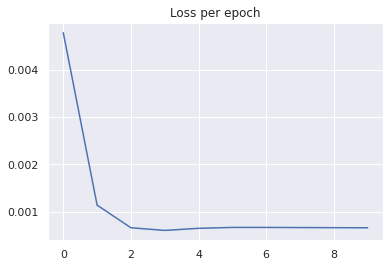

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.plot(epoch_loss)
plt.title('Loss per epoch')
plt.show()